<a href="https://colab.research.google.com/github/BirukovAlex/neto_Python/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE_%D1%82%D0%B5%D0%BC%D0%B5_%C2%AB%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D1%8B_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9%C2%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
from torchsummary import summary

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Создаем директорию для сохранения результатов
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

Используемое устройство: cuda


Размер тренировочного набора: 697932
Размер тестового набора: 116323
Количество классов: 62


100%|██████████| 2727/2727 [02:53<00:00, 15.69it/s]



Распределение классов:
Класс 0 (0): 34585 образцов
Класс 1 (1): 38374 образцов
Класс 2 (2): 34203 образцов
Класс 3 (3): 35143 образцов
Класс 4 (4): 33535 образцов
Класс 5 (5): 31416 образцов
Класс 6 (6): 34232 образцов
Класс 7 (7): 35754 образцов
Класс 8 (8): 33946 образцов
Класс 9 (9): 33847 образцов


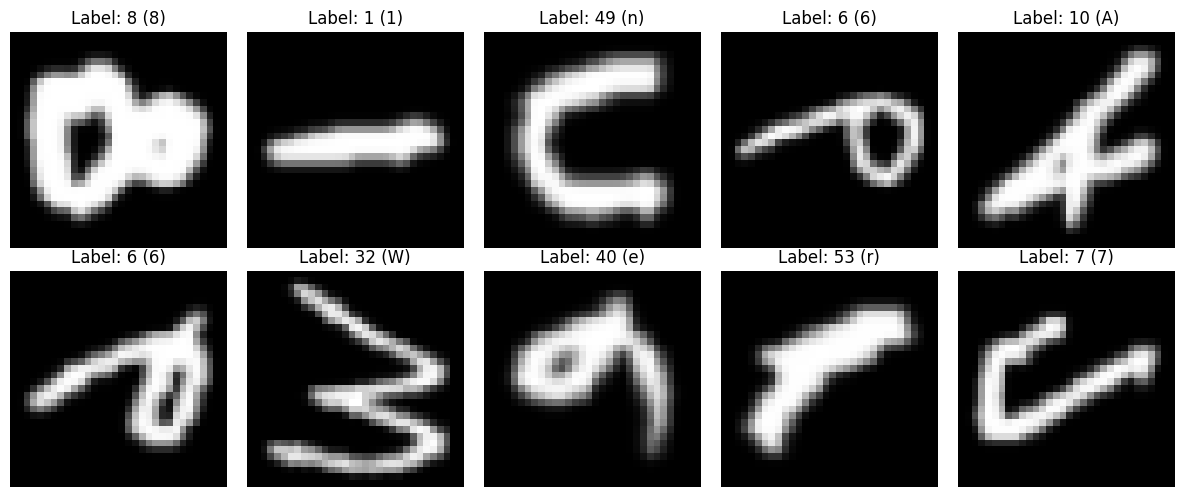

In [8]:
def load_emnist(batch_size=128):
    """
    Загрузка датасета EMNIST с преобразованиями
    """
    # Преобразования для изображений
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Изменяем размер для совместимости с моделями
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Нормализация для MNIST/EMNIST
    ])

    # Загрузка тренировочного и тестового наборов
    train_dataset = torchvision.datasets.EMNIST(
        root='./data',
        split='byclass',  # Все классы (62 класса: 10 цифр + 26 строчных + 26 прописных букв)
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.EMNIST(
        root='./data',
        split='byclass',
        train=False,
        download=True,
        transform=transform
    )

    # Создание DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, test_loader, train_dataset, test_dataset

# Загружаем данные
train_loader, test_loader, train_dataset, test_dataset = load_emnist(batch_size=256)

print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")
print(f"Количество классов: {len(train_dataset.classes)}")

# Анализ распределения классов
def analyze_class_distribution(dataset):
    """Анализ распределения классов в датасете"""
    class_counts = torch.zeros(len(dataset.classes))

    for _, label in tqdm(DataLoader(dataset, batch_size=256, shuffle=False)):
        for l in label:
            class_counts[l] += 1

    return class_counts

class_counts = analyze_class_distribution(train_dataset)
print("\nРаспределение классов:")
for i in range(min(10, len(class_counts))):  # Показываем первые 10 классов
    print(f"Класс {i} ({train_dataset.classes[i]}): {int(class_counts[i])} образцов")

# Визуализация нескольких примеров
def visualize_samples(dataset, num_samples=10):
    """Визуализация случайных примеров из датасета"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx, ax in enumerate(axes):
        if idx < num_samples:
            image, label = dataset[indices[idx]]
            ax.imshow(image.squeeze(), cmap='gray')
            ax.set_title(f'Label: {label} ({train_dataset.classes[label]})')
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('results/emnist_samples.png', dpi=150)
    plt.show()

visualize_samples(train_dataset)

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Обучение модели на одной эпохе"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Обновление прогресс-бара
        progress_bar.set_postfix({
            'loss': running_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Валидация модели"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation', leave=False)
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar.set_postfix({
                'loss': running_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total

    return val_loss, val_acc

def train_model(model, train_loader, test_loader, model_name, num_epochs=10, lr=0.001):
    """Полный цикл обучения модели"""
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    print(f"\n{'='*50}")
    print(f"Обучение модели: {model_name}")
    print(f"{'='*50}")

    for epoch in range(num_epochs):
        start_time = time.time()

        print(f"\nЭпоха {epoch+1}/{num_epochs}")

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Валидация
        val_loss, val_acc = validate(model, test_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Обновление learning rate
        scheduler.step()

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        print(f"Результаты: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
              f"Время: {epoch_time:.2f} сек")

    # Сохранение модели
    torch.save({
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'times': times
    }, f'models/{model_name}_emnist.pth')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'times': times
    }

def plot_training_results(results_dict, model_names):
    """Построение графиков обучения для всех моделей"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # График потерь на тренировке
    ax = axes[0, 0]
    for name in model_names:
        if name in results_dict:
            ax.plot(results_dict[name]['train_losses'], label=name, linewidth=2)
    ax.set_title('Train Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # График потерь на валидации
    ax = axes[0, 1]
    for name in model_names:
        if name in results_dict:
            ax.plot(results_dict[name]['val_losses'], label=name, linewidth=2)
    ax.set_title('Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # График точности на тренировке
    ax = axes[1, 0]
    for name in model_names:
        if name in results_dict:
            ax.plot(results_dict[name]['train_accs'], label=name, linewidth=2)
    ax.set_title('Train Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # График точности на валидации
    ax = axes[1, 1]
    for name in model_names:
        if name in results_dict:
            ax.plot(results_dict[name]['val_accs'], label=name, linewidth=2)
    ax.set_title('Validation Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/training_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

In [10]:
def create_resnet18(num_classes=62):
    """Создание модели ResNet-18"""
    model = torchvision.models.resnet18(pretrained=False)

    # Изменение входного слоя для одноканальных изображений
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Изменение выходного слоя для нужного количества классов
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

# Обучение ResNet-18
print("Подготовка ResNet-18...")
resnet18_model = create_resnet18(num_classes=62)
print("Архитектура ResNet-18:")
summary(resnet18_model.to(device), (1, 32, 32))

resnet18_results = train_model(
    model=resnet18_model,
    train_loader=train_loader,
    test_loader=test_loader,
    model_name='resnet18',
    num_epochs=3,
    lr=0.001
)

Подготовка ResNet-18...
Архитектура ResNet-18:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]         

Результаты: Train Loss: 0.4460, Train Acc: 84.19%, Val Loss: 0.3826, Val Acc: 85.90%, Время: 322.18 сек

Эпоха 2/3


Результаты: Train Loss: 0.3659, Train Acc: 86.39%, Val Loss: 0.3547, Val Acc: 86.85%, Время: 321.83 сек

Эпоха 3/3


Результаты: Train Loss: 0.3463, Train Acc: 86.92%, Val Loss: 0.3554, Val Acc: 86.68%, Время: 321.07 сек


In [12]:
def create_vgg16(num_classes=62):
    """Создание модели VGG-16"""
    model = torchvision.models.vgg16(pretrained=False)

    # Изменение входного слоя для одноканальных изображений
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

    # Изменение выходного слоя
    model.classifier[6] = nn.Linear(4096, num_classes)

    return model

# Обучение VGG-16
print("Подготовка VGG-16...")
vgg16_model = create_vgg16(num_classes=62)
print("Архитектура VGG-16:")
summary(vgg16_model.to(device), (1, 32, 32))

vgg16_results = train_model(
    model=vgg16_model,
    train_loader=train_loader,
    test_loader=test_loader,
    model_name='vgg16',
    num_epochs=3,
    lr=0.001
)

Подготовка VGG-16...
Архитектура VGG-16:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,08

Результаты: Train Loss: 0.8452, Train Acc: 75.51%, Val Loss: 0.4671, Val Acc: 84.49%, Время: 496.59 сек

Эпоха 2/3


Результаты: Train Loss: 0.4591, Train Acc: 84.66%, Val Loss: 0.4306, Val Acc: 84.71%, Время: 495.61 сек

Эпоха 3/3


Результаты: Train Loss: 0.4391, Train Acc: 85.17%, Val Loss: 0.4215, Val Acc: 85.44%, Время: 495.25 сек
